In [ ]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100%} important!</style>'))

/tmp/ipykernel_10823/163521364.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Librerías

In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from scipy.stats import ks_2samp

from varclushi import VarClusHi

import seaborn as sns

import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns',100)

# Lectura de Datos

In [ ]:
path = 'contaminantes_CDMX/'

In [ ]:
files = os.listdir(path)

In [ ]:
lst_df = []

for f in files:
    df = pd.read_csv( os.path.join( path , f ) , skiprows=10  )
    lst_df.append(df)
    print(df.shape)

print('\n')
df = pd.concat( lst_df , ignore_index=True )

print(df.shape)

(2128680, 5)
(2266536, 5)
(2292624, 5)
(2293704, 5)
(949488, 5)


(9931032, 5)


In [ ]:
df = df.pivot_table( index=['id_station','date'], columns=['id_parameter'], values=['value'] ).reset_index()

# Inspección /  Exploración

In [ ]:
df.columns = [ c[0][:1]+'_'+c[1] if c[1] != '' else c[0] for c in df.columns ]

In [ ]:
df['fh'] = df['date'].map( lambda x: x.split(' ')[0] )

In [ ]:
df['fh'] = pd.to_datetime(df['fh'] , format='%d/%m/%Y')

In [ ]:
df['hrs'] = df['date'].map( lambda x: x.split(' ')[1].split(':')[0] )

In [ ]:
df.rename(columns={'v_PM10':'PM10'},inplace=True)

In [ ]:
df = df.loc[~df.PM10.isna()].reset_index(drop=True)

## Variables

In [ ]:
um = ['id_station','fh']
tgt = ['PM10']
varc = df.filter(like='v_').columns.to_list()

## Ingeniería de Variables

In [ ]:
for i in varc:
    for j in varc:
        if i!= j:
            df[f'v_{i[2:]}_{j[2:]}_ratio'] = np.where( df[j] != 0 , df[i] / df[j] , np.nan  )

In [ ]:
df.shape

(603438, 69)

In [ ]:
varc = df.filter(like='v_').columns.to_list()

In [ ]:
df = df.groupby(um)[varc+tgt].mean().reset_index()

In [ ]:
for c in df.columns:
    print(c , df[c].map(type).unique().tolist() , "\n"*1 )

id_station [<class 'str'>] 

fh [<class 'pandas._libs.tslibs.timestamps.Timestamp'>] 

v_CO [<class 'float'>] 

v_NO [<class 'float'>] 

v_NO2 [<class 'float'>] 

v_NOX [<class 'float'>] 

v_O3 [<class 'float'>] 

v_PM2.5 [<class 'float'>] 

v_PMCO [<class 'float'>] 

v_SO2 [<class 'float'>] 

v_CO_NO_ratio [<class 'float'>] 

v_CO_NO2_ratio [<class 'float'>] 

v_CO_NOX_ratio [<class 'float'>] 

v_CO_O3_ratio [<class 'float'>] 

v_CO_PM2.5_ratio [<class 'float'>] 

v_CO_PMCO_ratio [<class 'float'>] 

v_CO_SO2_ratio [<class 'float'>] 

v_NO_CO_ratio [<class 'float'>] 

v_NO_NO2_ratio [<class 'float'>] 

v_NO_NOX_ratio [<class 'float'>] 

v_NO_O3_ratio [<class 'float'>] 

v_NO_PM2.5_ratio [<class 'float'>] 

v_NO_PMCO_ratio [<class 'float'>] 

v_NO_SO2_ratio [<class 'float'>] 

v_NO2_CO_ratio [<class 'float'>] 

v_NO2_NO_ratio [<class 'float'>] 

v_NO2_NOX_ratio [<class 'float'>] 

v_NO2_O3_ratio [<class 'float'>] 

v_NO2_PM2.5_ratio [<class 'float'>] 

v_NO2_PMCO_ratio [<class 'float'>]

In [ ]:
df = df.loc[ ( ~df.fh.isnull() ) ].reset_index(drop=True)

In [ ]:
df.shape

(26503, 67)

## Catálogo de Fechas

In [ ]:
cat_fh = df[['fh']].drop_duplicates().reset_index(drop=True)

In [ ]:
cat_fh['fh'] = sorted(cat_fh['fh'])

In [ ]:
cat_fh['ancla'] = cat_fh.index + 1

In [ ]:
( cat_fh['fh'].max() - cat_fh['fh'].min() ) / np.timedelta64(1,'D')

1611.0

## Ventanas de Tiempo

In [ ]:
vdes = 1
vobs = 6

fh_ini = cat_fh['ancla'].min()
fh_fin = cat_fh['ancla'].max()

print( fh_ini , fh_fin )

ancla_i = fh_ini + vobs - 1
ancla_f = fh_fin - vdes

print( ancla_i , ancla_f )

1 1612
6 1611


In [ ]:
df = df.merge( cat_fh , on=['fh'] , how = 'inner').reset_index(drop=True)

In [ ]:
um = ['ancla','id_station']

In [ ]:
X = df[um+varc+tgt].copy()

In [ ]:
X

,ancla,id_station,v_CO,v_NO,v_NO2,v_NOX,v_O3,v_PM2.5,v_PMCO,v_SO2,v_CO_NO_ratio,v_CO_NO2_ratio,v_CO_NOX_ratio,v_CO_O3_ratio,v_CO_PM2.5_ratio,v_CO_PMCO_ratio,v_CO_SO2_ratio,v_NO_CO_ratio,v_NO_NO2_ratio,v_NO_NOX_ratio,v_NO_O3_ratio,v_NO_PM2.5_ratio,v_NO_PMCO_ratio,v_NO_SO2_ratio,v_NO2_CO_ratio,v_NO2_NO_ratio,v_NO2_NOX_ratio,v_NO2_O3_ratio,v_NO2_PM2.5_ratio,v_NO2_PMCO_ratio,v_NO2_SO2_ratio,v_NOX_CO_ratio,v_NOX_NO_ratio,v_NOX_NO2_ratio,v_NOX_O3_ratio,v_NOX_PM2.5_ratio,v_NOX_PMCO_ratio,v_NOX_SO2_ratio,v_O3_CO_ratio,v_O3_NO_ratio,v_O3_NO2_ratio,v_O3_NOX_ratio,v_O3_PM2.5_ratio,v_O3_PMCO_ratio,v_O3_SO2_ratio,v_PM2.5_CO_ratio,v_PM2.5_NO_ratio,v_PM2.5_NO2_ratio,v_PM2.5_NOX_ratio,v_PM2.5_O3_ratio,v_PM2.5_PMCO_ratio,v_PM2.5_SO2_ratio,v_PMCO_CO_ratio,v_PMCO_NO_ratio,v_PMCO_NO2_ratio,v_PMCO_NOX_ratio,v_PMCO_O3_ratio,v_PMCO_PM2.5_ratio,v_PMCO_SO2_ratio,v_SO2_CO_ratio,v_SO2_NO_ratio,v_SO2_NO2_ratio,v_SO2_NOX_ratio,v_SO2_O3_ratio,v_SO2_PM2.5_ratio,v_SO2_PMCO_ratio,PM10
0,1,ACO,0.237500,2.000000,12.875000,14.750000,14.291667,NaN,NaN,1.583333,0.118056,0.018796,0.016159,0.021586,NaN,NaN,0.158333,10.868056,0.173730,0.146759,0.187860,NaN,NaN,1.541667,66.736111,6.625000,0.862210,1.296302,NaN,NaN,9.666667,77.395833,7.611111,1.164429,1.469520,NaN,NaN,11.152778,87.083333,7.659722,1.490244,1.222494,NaN,NaN,10.687500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.395833,0.812500,0.131808,0.112715,0.132601,NaN,NaN,54.125000
1,1,AJM,0.533333,2.916667,17.625000,20.250000,37.458333,49.625000,18.291667,14.166667,0.277049,0.030566,0.026860,0.020745,0.013039,0.031668,0.051185,5.059524,0.158270,0.131253,0.123122,0.061084,0.170702,0.221107,33.454365,9.452083,0.884289,0.699181,0.445129,1.031712,1.672781,37.946925,10.280208,1.141814,0.811810,0.497311,1.186359,1.863336,78.119544,23.464931,2.355730,2.106629,0.865911,2.333193,3.607469,90.872024,24.282639,2.810704,2.439861,1.775934,2.982241,4.461138,36.064980,10.245139,1.059140,0.944887,0.697543,0.508740,1.834237,27.613591,6.742708,0.827536,0.715372,0.537388,0.345382,0.880378,68.000000
2,1,ATI,0.176190,NaN,NaN,NaN,26.952381,NaN,NaN,32.571429,NaN,NaN,NaN,0.012998,NaN,NaN,0.011497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.761905,NaN,NaN,NaN,NaN,NaN,2.881428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194.126984,NaN,NaN,NaN,2.996167,NaN,NaN,47.000000
3,1,BJU,0.387500,NaN,NaN,NaN,34.166667,44.208333,16.916667,24.500000,NaN,NaN,NaN,0.025301,0.012131,0.030784,0.039976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.638889,NaN,NaN,NaN,1.039034,2.389494,4.213847,106.562500,NaN,NaN,NaN,2.717751,3.611056,3.389002,52.305556,NaN,NaN,NaN,0.884006,0.869163,3.240826,59.770833,NaN,NaN,NaN,2.887809,0.568230,2.474175,61.208333
4,1,CUA,0.195833,2.375000,16.500000,18.625000,20.083333,NaN,NaN,13.208333,0.095574,0.010437,0.009200,0.013053,NaN,NaN,0.020836,12.839286,0.144424,0.121779,0.170337,NaN,NaN,0.193075,94.241667,9.557513,0.889557,1.076522,NaN,NaN,1.603602,106.434524,10.446086,1.132468,1.229085,NaN,NaN,1.768834,161.994048,13.857702,1.406112,1.251154,NaN,NaN,1.831720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.936905,7.632639,0.939683,0.811209,0.844474,NaN,NaN,56.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26498,1563,TAH,0.195000,2.350000,9.550000,12.000000,36.650000,NaN,NaN,1.000000,0.123026,0.022340,0.017120,0.014564,NaN,NaN,0.195000,10.657895,0.241415,0.176147,0.213167,NaN,NaN,2.350000,48.859649,6.101243,0.804380,0.675916,NaN,NaN,9.550000,60.745614,7.253289,1.270627,0.882459,NaN,NaN,12.000000,303.815789,32.149854,8.758179,6.676488,NaN,NaN,36.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.061404,0.789839,0.183326,0.142102,0.043725,NaN,NaN,51.476190
26499,1563,TLA,0.

## Ventanas

In [ ]:
def ventanas( df , variable , ancla ):

    aux = df.loc[ ( df['ancla'] >= ( ancla-vobs+1 ) ) & (  df['ancla'] <= ancla ) ].reset_index(drop=True)
    aux = aux.pivot_table( index = 'id_station' , values=variable , aggfunc = ['min','max','mean'] )
    aux.columns = [f'x_{a}_{b}_{vobs}' for a,b in aux.columns]
    aux.insert(0, 'ancla', ancla)

    return aux.reset_index()

In [ ]:
X = pd.concat( map( lambda ancla: ventanas( X , varc , ancla ) , range(ancla_i, ancla_f + 1 )  ) , ignore_index=True  )

## Vector solución

In [ ]:
def var_obje(df, ancla):
    aux = df[um +tgt].loc[ df.ancla == (ancla + vdes)].reset_index(drop=True)
    aux.rename(columns={tgt[0]:'y'},inplace=True)
    return aux

In [ ]:
y = pd.concat( map( lambda ancla: var_obje(df,ancla) , range(ancla_i,ancla_f+1)    )  , ignore_index=True)

In [ ]:
varc = X.filter(like='x_').columns.to_list()

## TAD inicial

In [ ]:
tad = X.merge( y , on = um , how='inner')

# Análisis Univariado

In [ ]:
X[varc].describe(percentiles=[0.01,0.5,0.95,0.99])

,x_min_v_CO_6,x_min_v_CO_NO2_ratio_6,x_min_v_CO_NOX_ratio_6,x_min_v_CO_NO_ratio_6,x_min_v_CO_O3_ratio_6,x_min_v_CO_PM2.5_ratio_6,x_min_v_CO_PMCO_ratio_6,x_min_v_CO_SO2_ratio_6,x_min_v_NO_6,x_min_v_NO2_6,x_min_v_NO2_CO_ratio_6,x_min_v_NO2_NOX_ratio_6,x_min_v_NO2_NO_ratio_6,x_min_v_NO2_O3_ratio_6,x_min_v_NO2_PM2.5_ratio_6,x_min_v_NO2_PMCO_ratio_6,x_min_v_NO2_SO2_ratio_6,x_min_v_NOX_6,x_min_v_NOX_CO_ratio_6,x_min_v_NOX_NO2_ratio_6,x_min_v_NOX_NO_ratio_6,x_min_v_NOX_O3_ratio_6,x_min_v_NOX_PM2.5_ratio_6,x_min_v_NOX_PMCO_ratio_6,x_min_v_NOX_SO2_ratio_6,x_min_v_NO_CO_ratio_6,x_min_v_NO_NO2_ratio_6,x_min_v_NO_NOX_ratio_6,x_min_v_NO_O3_ratio_6,x_min_v_NO_PM2.5_ratio_6,x_min_v_NO_PMCO_ratio_6,x_min_v_NO_SO2_ratio_6,x_min_v_O3_6,x_min_v_O3_CO_ratio_6,x_min_v_O3_NO2_ratio_6,x_min_v_O3_NOX_ratio_6,x_min_v_O3_NO_ratio_6,x_min_v_O3_PM2.5_ratio_6,x_min_v_O3_PMCO_ratio_6,x_min_v_O3_SO2_ratio_6,x_min_v_PM2.5_6,x_min_v_PM2.5_CO_ratio_6,x_min_v_PM2.5_NO2_ratio_6,x_min_v_PM2.5_NOX_ratio_6,x_min_v_PM2.5_NO_ratio_6,x_min_v_PM2.5_O3_ratio_6,x_min_v_PM2.5_PMCO_ratio_6,x_min_v_PM2.5_SO2_ratio_6,x_min_v_PMCO_6,x_min_v_PMCO_CO_ratio_6,...,x_mean_v_NO2_PM2.5_ratio_6,x_mean_v_NO2_PMCO_ratio_6,x_mean_v_NO2_SO2_ratio_6,x_mean_v_NOX_6,x_mean_v_NOX_CO_ratio_6,x_mean_v_NOX_NO2_ratio_6,x_mean_v_NOX_NO_ratio_6,x_mean_v_NOX_O3_ratio_6,x_mean_v_NOX_PM2.5_ratio_6,x_mean_v_NOX_PMCO_ratio_6,x_mean_v_NOX_SO2_ratio_6,x_mean_v_NO_CO_ratio_6,x_mean_v_NO_NO2_ratio_6,x_mean_v_NO_NOX_ratio_6,x_mean_v_NO_O3_ratio_6,x_mean_v_NO_PM2.5_ratio_6,x_mean_v_NO_PMCO_ratio_6,x_mean_v_NO_SO2_ratio_6,x_mean_v_O3_6,x_mean_v_O3_CO_ratio_6,x_mean_v_O3_NO2_ratio_6,x_mean_v_O3_NOX_ratio_6,x_mean_v_O3_NO_ratio_6,x_mean_v_O3_PM2.5_ratio_6,x_mean_v_O3_PMCO_ratio_6,x_mean_v_O3_SO2_ratio_6,x_mean_v_PM2.5_6,x_mean_v_PM2.5_CO_ratio_6,x_mean_v_PM2.5_NO2_ratio_6,x_mean_v_PM2.5_NOX_ratio_6,x_mean_v_PM2.5_NO_ratio_6,x_mean_v_PM2.5_O3_ratio_6,x_mean_v_PM2.5_PMCO_ratio_6,x_mean_v_PM2.5_SO2_ratio_6,x_mean_v_PMCO_6,x_mean_v_PMCO_CO_ratio_6,x_mean_v_PMCO_NO2_ratio_6,x_mean_v_PMCO_NOX_ratio_6,x_mean_v_PMCO_NO_ratio_6,x_mean_v_PMCO_O3_ratio_6,x_mean_v_PMCO_PM2.5_ratio_6,x_mean_v_PMCO_SO2_ratio_6,x_mean_v_SO2_6,x_mean_v_SO2_CO_ratio_6,x_mean_v_SO2_NO2_ratio_6,x_mean_v_SO2_NOX_ratio_6,x_mean_v_SO2_NO_ratio_6,x_mean_v_SO2_O3_ratio_6,x_mean_v_SO2_PM2.5_ratio_6,x_mean_v_SO2_PMCO_ratio_6
count,24456.000000,22397.000000,21092.000000,21088.000000,24323.000000,14764.000000,14409.000000,23556.000000,23289.000000,25275.000000,22397.000000,23289.000000,23285.000000,25124.000000,14103.000000,13748.000000,23653.000000,23289.000000,21092.000000,23289.000000,23285.000000,23140.000000,12117.000000,11762.000000,22394.000000,21092.000000,23289.000000,23289.000000,23140.000000,12117.000000,11762.000000,22394.000000,27297.000000,24323.000000,25124.000000,23140.000000,23137.000000,15738.000000,15398.000000,25527.000000,15970.000000,14764.000000,14103.000000,12117.000000,12115.000000,15738.000000,15603.000000,14434.000000,15603.000000,14409.000000,...,14103.000000,13748.000000,23653.000000,23289.000000,21092.000000,23289.000000,23285.000000,23140.000000,12117.000000,11762.000000,22394.000000,21092.000000,23289.000000,23289.000000,23140.000000,12117.000000,11762.000000,22394.000000,27297.000000,24323.000000,25124.000000,23140.000000,23137.000000,15738.000000,15398.000000,25527.000000,15970.000000,14764.000000,14103.000000,12117.000000,12115.000000,15738.000000,15603.000000,14434.000000,15603.000000,14409.000000,13748.000000,11762.000000,11760.000000,15398.000000,15603.000000,14091.000000,25697.000000,23561.000000,23656.000000,22397.000000,22393.000000,25532.000000,14436.000000,14093.000000
mean,0.258959,0.013438,0.009318,0.055624,0.034629,0.015452,0.018607,0.123528,6.495768,17.039957,57.740968,0.693802,4.184300,2.059284,1.075288,1.310878,7.762609,24.485605,78.394940,1.270073,5.172126,3.808694,1.551863,1.908040,11.011260,15.764163,0.271064,0.168672,1.621207,0.393833,0.482368,2.701048,22.076440,94.136139,1.524885,1.220075,8.267044,1.27

array([[<AxesSubplot:title={'center':'x_min_v_CO_6'}>,
        <AxesSubplot:title={'center':'x_min_v_CO_NO2_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_CO_NOX_ratio_6'}>],
       [<AxesSubplot:title={'center':'x_min_v_CO_NO_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_CO_O3_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_CO_PM2.5_ratio_6'}>],
       [<AxesSubplot:title={'center':'x_min_v_CO_PMCO_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_CO_SO2_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NO_6'}>]], dtype=object)

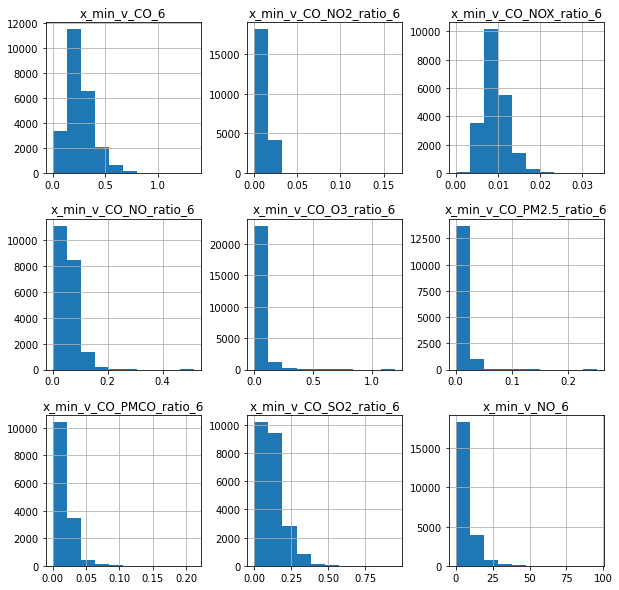

In [ ]:
X[varc[:9]].hist(figsize=(10,10))

## Ausentes

In [ ]:
miss = 1 - X[varc].describe().T[['count']]  / len(df)
miss

,count
x_min_v_CO_6,0.077237
x_min_v_CO_NO2_ratio_6,0.154926
x_min_v_CO_NOX_ratio_6,0.204166
x_min_v_CO_NO_ratio_6,0.204316
x_min_v_CO_O3_ratio_6,0.082255
...,...
x_mean_v_SO2_NOX_ratio_6,0.154926
x_mean_v_SO2_NO_ratio_6,0.155077
x_mean_v_SO2_O3_ratio_6,0.036637
x_mean_v_SO2_PM2.5_ratio_6,0.455307


In [ ]:
X.shape , X.dropna().shape , X.dropna().shape[0] / X.shape[0]

((27589, 194), (10769, 194), 0.3903367284062489)

## Imputación

In [ ]:
im = SimpleImputer(strategy='median')

In [ ]:
im.fit(X[varc])

SimpleImputer(strategy='median')

In [ ]:
X[varc] = im.transform(X[varc])

In [ ]:
X.shape , X.dropna().shape , X.dropna().shape[0] / X.shape[0]

((27589, 194), (27589, 194), 1.0)

## Validación de distribución no alterada

In [ ]:
ks =  pd.DataFrame( map(  lambda v: (v , ks_2samp( tad[v].dropna() , X[v] ).statistic ) , varc ) , columns = ['var','ks']  )

In [ ]:
ks

,var,ks
0,x_min_v_CO_6,0.062704
1,x_min_v_CO_NO2_ratio_6,0.099588
2,x_min_v_CO_NOX_ratio_6,0.120568
3,x_min_v_CO_NO_ratio_6,0.118647
4,x_min_v_CO_O3_ratio_6,0.065822
...,...,...
187,x_mean_v_SO2_NOX_ratio_6,0.099004
188,x_mean_v_SO2_NO_ratio_6,0.098853
189,x_mean_v_SO2_O3_ratio_6,0.037859
190,x_mean_v_SO2_PM2.5_ratio_6,0.238558


In [ ]:
alteradas = ks['var'].loc[ ks['ks'] >.1 ].to_list()

In [ ]:
len(alteradas) , alteradas

(102,
 ['x_min_v_CO_NOX_ratio_6',
  'x_min_v_CO_NO_ratio_6',
  'x_min_v_CO_PM2.5_ratio_6',
  'x_min_v_CO_PMCO_ratio_6',
  'x_min_v_NO2_CO_ratio_6',
  'x_min_v_NO2_PM2.5_ratio_6',
  'x_min_v_NO2_PMCO_ratio_6',
  'x_min_v_NOX_CO_ratio_6',
  'x_min_v_NOX_PM2.5_ratio_6',
  'x_min_v_NOX_PMCO_ratio_6',
  'x_min_v_NOX_SO2_ratio_6',
  'x_min_v_NO_CO_ratio_6',
  'x_min_v_NO_PM2.5_ratio_6',
  'x_min_v_NO_PMCO_ratio_6',
  'x_min_v_NO_SO2_ratio_6',
  'x_min_v_O3_PM2.5_ratio_6',
  'x_min_v_O3_PMCO_ratio_6',
  'x_min_v_PM2.5_6',
  'x_min_v_PM2.5_CO_ratio_6',
  'x_min_v_PM2.5_NO2_ratio_6',
  'x_min_v_PM2.5_NOX_ratio_6',
  'x_min_v_PM2.5_NO_ratio_6',
  'x_min_v_PM2.5_O3_ratio_6',
  'x_min_v_PM2.5_PMCO_ratio_6',
  'x_min_v_PM2.5_SO2_ratio_6',
  'x_min_v_PMCO_6',
  'x_min_v_PMCO_CO_ratio_6',
  'x_min_v_PMCO_NO2_ratio_6',
  'x_min_v_PMCO_NOX_ratio_6',
  'x_min_v_PMCO_NO_ratio_6',
  'x_min_v_PMCO_O3_ratio_6',
  'x_min_v_PMCO_PM2.5_ratio_6',
  'x_min_v_PMCO_SO2_ratio_6',
  'x_min_v_SO2_PM2.5_ratio_6',
  'x

In [ ]:
varc = [v for v in varc if v not in alteradas]

In [ ]:
len(varc)

90

## Varianza

In [ ]:
vt = VarianceThreshold(threshold=1)
vt.fit(X[varc])

VarianceThreshold(threshold=1)

In [ ]:
sin_varianza = [v for v,u in zip( varc , vt.get_support() ) if not(u) ]

In [ ]:
len(sin_varianza) , sin_varianza

(33,
 ['x_min_v_CO_6',
  'x_min_v_CO_NO2_ratio_6',
  'x_min_v_CO_O3_ratio_6',
  'x_min_v_CO_SO2_ratio_6',
  'x_min_v_NO2_NOX_ratio_6',
  'x_min_v_NOX_NO2_ratio_6',
  'x_min_v_NO_NO2_ratio_6',
  'x_min_v_NO_NOX_ratio_6',
  'x_min_v_O3_NOX_ratio_6',
  'x_min_v_SO2_NO2_ratio_6',
  'x_min_v_SO2_NOX_ratio_6',
  'x_min_v_SO2_NO_ratio_6',
  'x_min_v_SO2_O3_ratio_6',
  'x_max_v_CO_6',
  'x_max_v_CO_O3_ratio_6',
  'x_max_v_CO_SO2_ratio_6',
  'x_max_v_NO2_NOX_ratio_6',
  'x_max_v_NOX_NO2_ratio_6',
  'x_max_v_NO_NO2_ratio_6',
  'x_max_v_NO_NOX_ratio_6',
  'x_max_v_SO2_NO2_ratio_6',
  'x_mean_v_CO_6',
  'x_mean_v_CO_NO2_ratio_6',
  'x_mean_v_CO_O3_ratio_6',
  'x_mean_v_CO_SO2_ratio_6',
  'x_mean_v_NO2_NOX_ratio_6',
  'x_mean_v_NOX_NO2_ratio_6',
  'x_mean_v_NO_NO2_ratio_6',
  'x_mean_v_NO_NOX_ratio_6',
  'x_mean_v_SO2_NO2_ratio_6',
  'x_mean_v_SO2_NOX_ratio_6',
  'x_mean_v_SO2_NO_ratio_6',
  'x_mean_v_SO2_O3_ratio_6'])

In [ ]:
X.drop(sin_varianza, axis=1, inplace=True)

In [ ]:
varc = [v for v in varc if v not in sin_varianza]

len(varc), varc

(57,
 ['x_min_v_NO_6',
  'x_min_v_NO2_6',
  'x_min_v_NO2_NO_ratio_6',
  'x_min_v_NO2_O3_ratio_6',
  'x_min_v_NO2_SO2_ratio_6',
  'x_min_v_NOX_6',
  'x_min_v_NOX_NO_ratio_6',
  'x_min_v_NOX_O3_ratio_6',
  'x_min_v_NO_O3_ratio_6',
  'x_min_v_O3_6',
  'x_min_v_O3_CO_ratio_6',
  'x_min_v_O3_NO2_ratio_6',
  'x_min_v_O3_NO_ratio_6',
  'x_min_v_O3_SO2_ratio_6',
  'x_min_v_SO2_6',
  'x_min_v_SO2_CO_ratio_6',
  'x_max_v_NO_6',
  'x_max_v_NO2_6',
  'x_max_v_NO2_CO_ratio_6',
  'x_max_v_NO2_NO_ratio_6',
  'x_max_v_NO2_O3_ratio_6',
  'x_max_v_NO2_SO2_ratio_6',
  'x_max_v_NOX_6',
  'x_max_v_NOX_NO_ratio_6',
  'x_max_v_NOX_O3_ratio_6',
  'x_max_v_NOX_SO2_ratio_6',
  'x_max_v_NO_O3_ratio_6',
  'x_max_v_NO_SO2_ratio_6',
  'x_max_v_O3_6',
  'x_max_v_O3_CO_ratio_6',
  'x_max_v_O3_NO2_ratio_6',
  'x_max_v_O3_NOX_ratio_6',
  'x_max_v_O3_NO_ratio_6',
  'x_max_v_O3_SO2_ratio_6',
  'x_max_v_SO2_6',
  'x_max_v_SO2_CO_ratio_6',
  'x_max_v_SO2_O3_ratio_6',
  'x_mean_v_NO_6',
  'x_mean_v_NO2_6',
  'x_mean_v_NO2_C

## Valores Extremos

In [ ]:
ext = X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index()
for v, li, ls in ext.values:
    X[f'ol_{v}'] = ((X[v] < li) | (X[v]>ls)).astype(int)

X['ext'] =  X.filter(like='ol_').max(axis=1)
X.drop(X.filter(like='ol_').columns, axis=1, inplace=True)

In [ ]:
X['ext'].value_counts(True)

0    0.736598
1    0.263402
Name: ext, dtype: float64

In [ ]:
X[um] = tad[um]

In [ ]:
X = X.loc[X['ext'] == 0].reset_index(drop=True).drop(['ext'],axis=1)

array([[<AxesSubplot:title={'center':'x_min_v_NO_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NO2_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NO2_NO_ratio_6'}>],
       [<AxesSubplot:title={'center':'x_min_v_NO2_O3_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NO2_SO2_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NOX_6'}>],
       [<AxesSubplot:title={'center':'x_min_v_NOX_NO_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NOX_O3_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NO_O3_ratio_6'}>]],
      dtype=object)

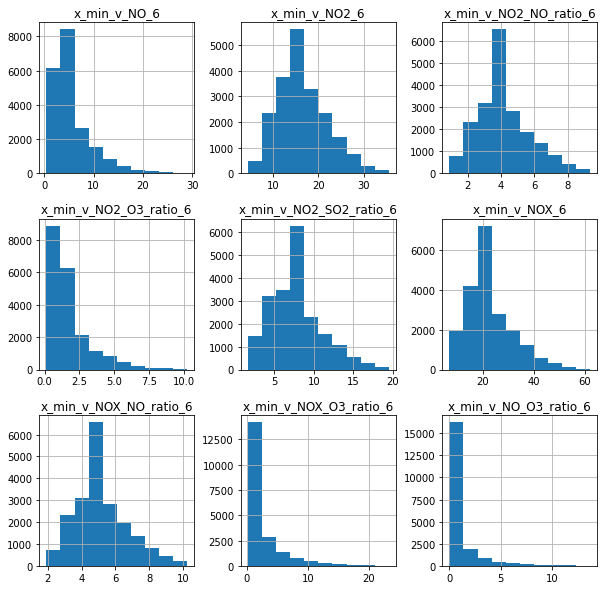

In [ ]:
X[varc[:9]].hist(figsize=(10,10))

# Análisis Bivariado

In [ ]:
X[varc].corr()

,x_min_v_NO_6,x_min_v_NO2_6,x_min_v_NO2_NO_ratio_6,x_min_v_NO2_O3_ratio_6,x_min_v_NO2_SO2_ratio_6,x_min_v_NOX_6,x_min_v_NOX_NO_ratio_6,x_min_v_NOX_O3_ratio_6,x_min_v_NO_O3_ratio_6,x_min_v_O3_6,x_min_v_O3_CO_ratio_6,x_min_v_O3_NO2_ratio_6,x_min_v_O3_NO_ratio_6,x_min_v_O3_SO2_ratio_6,x_min_v_SO2_6,x_min_v_SO2_CO_ratio_6,x_max_v_NO_6,x_max_v_NO2_6,x_max_v_NO2_CO_ratio_6,x_max_v_NO2_NO_ratio_6,x_max_v_NO2_O3_ratio_6,x_max_v_NO2_SO2_ratio_6,x_max_v_NOX_6,x_max_v_NOX_NO_ratio_6,x_max_v_NOX_O3_ratio_6,x_max_v_NOX_SO2_ratio_6,x_max_v_NO_O3_ratio_6,x_max_v_NO_SO2_ratio_6,x_max_v_O3_6,x_max_v_O3_CO_ratio_6,x_max_v_O3_NO2_ratio_6,x_max_v_O3_NOX_ratio_6,x_max_v_O3_NO_ratio_6,x_max_v_O3_SO2_ratio_6,x_max_v_SO2_6,x_max_v_SO2_CO_ratio_6,x_max_v_SO2_O3_ratio_6,x_mean_v_NO_6,x_mean_v_NO2_6,x_mean_v_NO2_CO_ratio_6,x_mean_v_NO2_NO_ratio_6,x_mean_v_NO2_O3_ratio_6,x_mean_v_NO2_SO2_ratio_6,x_mean_v_NOX_6,x_mean_v_NOX_NO_ratio_6,x_mean_v_NOX_O3_ratio_6,x_mean_v_NOX_SO2_ratio_6,x_mean_v_NO_O3_ratio_6,x_mean_v_NO_SO2_ratio_6,x_mean_v_O3_6,x_mean_v_O3_CO_ratio_6,x_mean_v_O3_NO2_ratio_6,x_mean_v_O3_NOX_ratio_6,x_mean_v_O3_NO_ratio_6,x_mean_v_O3_SO2_ratio_6,x_mean_v_SO2_6,x_mean_v_SO2_CO_ratio_6
x_min_v_NO_6,1.000000,0.636849,-0.364964,0.695623,0.101408,0.882592,-0.363960,0.811553,0.815270,-0.178223,-0.280045,-0.332385,-0.330715,-0.277033,0.363069,0.060189,0.608779,0.487031,0.068303,-0.378178,0.456275,0.050091,0.618481,-0.376724,0.529607,0.195263,0.513144,0.284856,-0.254252,-0.389885,-0.468246,-0.502301,-0.461498,-0.384971,0.179447,0.040546,0.289042,0.769976,0.586304,0.089616,-0.425920,0.577758,0.088307,0.753302,-0.424436,0.653247,0.289334,0.636578,0.457239,-0.243324,-0.382687,-0.458598,-0.486575,-0.456036,-0.377037,0.252204,0.044095
x_min_v_NO2_6,0.636849,1.000000,-0.039085,0.631279,0.165057,0.880985,-0.037542,0.521262,0.432657,-0.014817,-0.201653,-0.390758,-0.212991,-0.232346,0.409932,0.121041,0.488817,0.723372,0.295070,0.036796,0.513427,0.227354,0.621717,0.038079,0.429041,0.209694,0.372504,0.143467,-0.024910,-0.291072,-0.588839,-0.545501,-0.256796,-0.293829,0.233561,0.109152,0.309697,0.589307,0.885100,0.334916,0.001251,0.607147,0.253268,0.764714,0.003595,0.498735,0.272156,0.431943,0.232661,-0.019618,-0.285088,-0.557862,-0.515348,-0.273271,-0.299617,0.301556,0.115792
x_min_v_NO2_NO_ratio_6,-0.364964,-0.039085,1.000000,-0.236569,0.025246,-0.212812,0.999316,-0.258381,-0.252547,0.484939,0.409559,0.336431,0.689993,0.288194,-0.050578,0.102006,-0.488227,-0.145448,0.110649,0.603451,-0.344513,0.012658,-0.383484,0.603005,-0.423801,-0.217198,-0.426356,-0.411467,0.404024,0.375615,0.229281,0.326332,0.555115,0.290203,-0.064865,-0.000397,-0.177253,-0.491117,-0.103534,0.163297,0.843572,-0.344624,0.029085,-0.346747,0.843493,-0.416675,-0.212350,-0.424878,-0.454249,0.489966,0.431974,0.301087,0.399890,0.682617,0.324859,-0.076226,0.031305
x_min_v_NO2_O3_ratio_6,0.695623,0.631279,-0.236569,1.000000,0.059557,0.695348,-0.235683,0.874949,0.778450,-0.263100,-0.295305,-0.330119,-0.268600,-0.329484,0.319075,0.030410,0.504483,0.457739,0.071824,-0.168244,0.629091,0.072148,0.513070,-0.167346,0.570522,0.163753,0.529298,0.226546,-0.336198,-0.387997,-0.439504,-0.417300,-0.360242,-0.413459,0.187960,0.031749,0.369827,0.615552,0.565961,0.072971,-0.229813,0.801236,0.083968,0.623283,-0.228456,0.708993,0.218920,0.652573,0.338166,-0.337188,-0.388908,-0.438380,-0.412527,-0.357371,-0.418667,0.244526,0.028432
x_min_v_NO2_SO2_ratio_6,0.101408,0.165057,0.025246,0.059557,1.000000,0.151512,0.026127,0.061029,0.054164,0.029140,-0.016700,-0.025142,-0.005771,0.394269,-0.325199,-0.332875,-0.050785,0.031150,-0.022311,0.013541,0.004149,0.502001,-0.023105,0.013998,-0.027197,0.430374,-0.039819,0.279487,0.043880,-0.062161,-0.118942,-0.107147,-0.007010,0.292640,-0.569276,-0.544628,-0.362778,-0.008187,0.097362,-0.005737,0.029783,0.016526,0.789767,0.041251,0.030643,-0.011381,0.709577,-0.025699,0.457081,0.038909,-0.046275,-0.083902,-0.074019,-0.009404,0.373257,-0.570423,-0.561338
x_min_v_NOX_6,0.882592,0.880985,

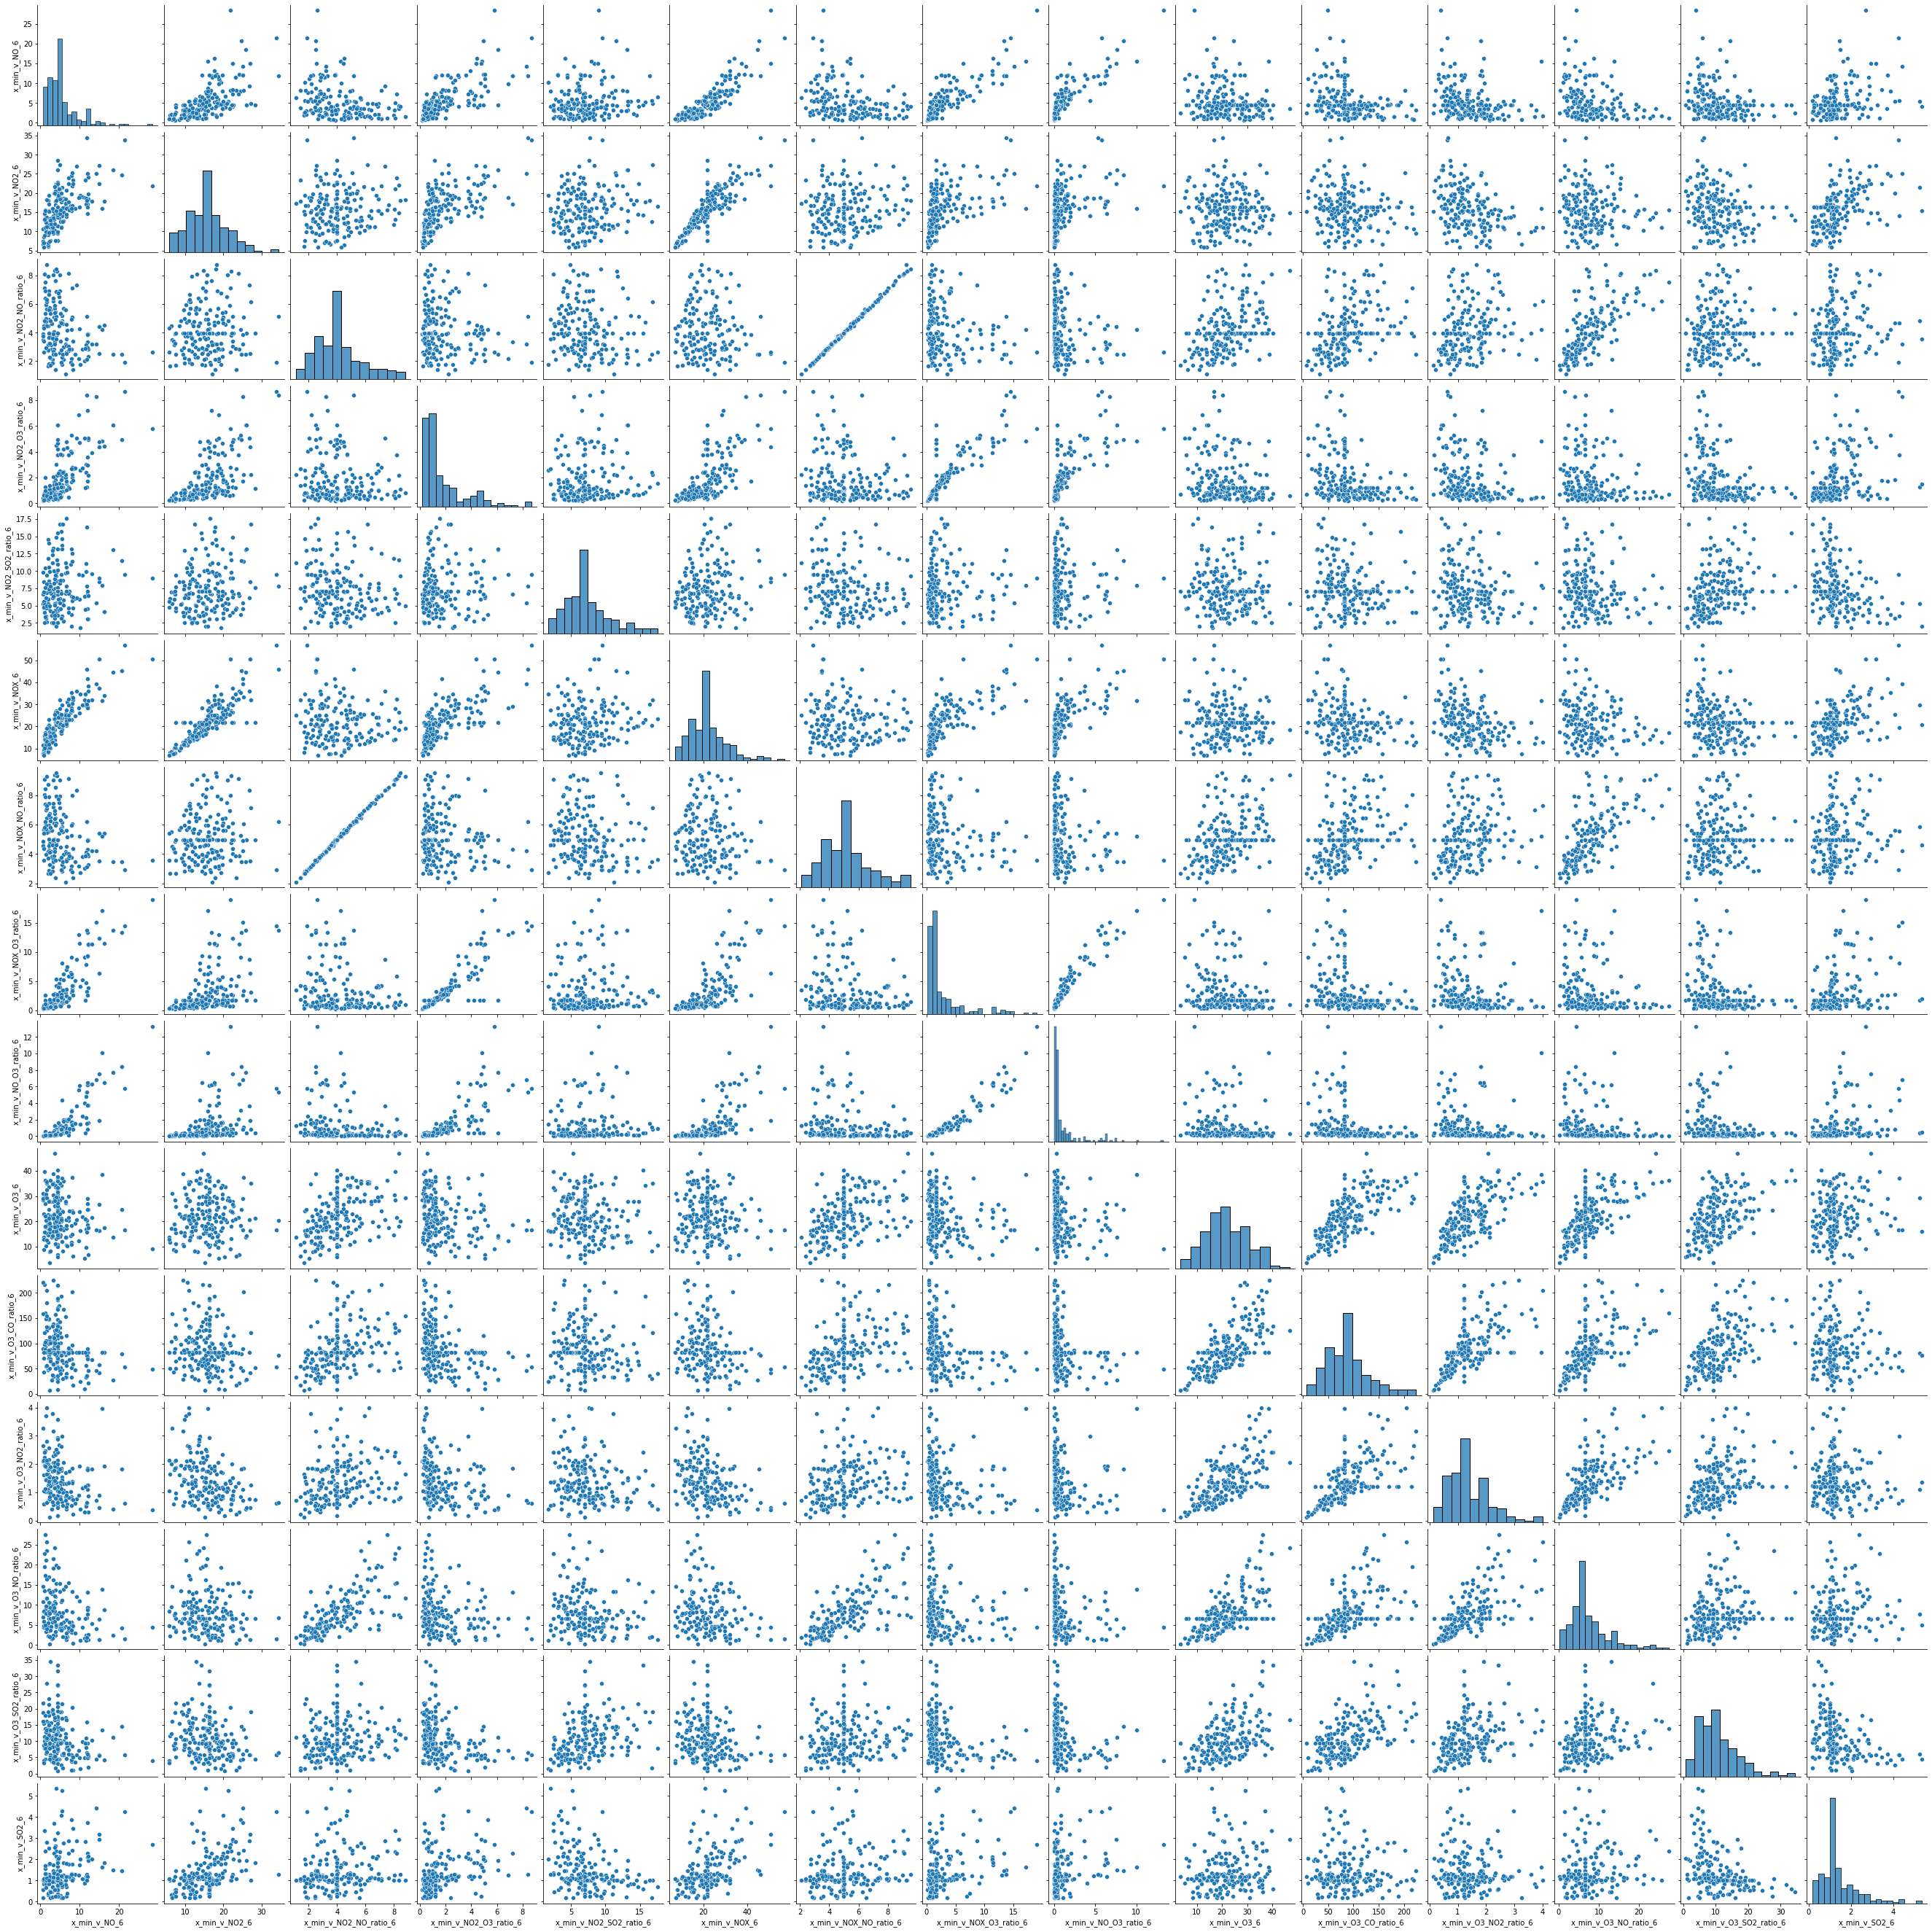

In [ ]:
sns.pairplot(X[varc[:15]].sample(200))

# Multicolinealidad

In [ ]:
vc = VarClusHi( df=X[varc] , feat_list=varc )

In [ ]:
vc.varclus()

In [ ]:
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio'] , ascending=[1,1] ).reset_index(drop=True)

In [ ]:
rs['id'] = rs.groupby('Cluster').cumcount()+1

In [ ]:
varc = rs.loc[rs['id'] == 1]['Variable'].tolist()

In [ ]:
len(varc), varc

(11,
 ['x_max_v_NOX_O3_ratio_6',
  'x_mean_v_NO2_SO2_ratio_6',
  'x_mean_v_O3_6',
  'x_mean_v_NOX_NO_ratio_6',
  'x_mean_v_SO2_CO_ratio_6',
  'x_mean_v_NO2_6',
  'x_mean_v_O3_NOX_ratio_6',
  'x_max_v_NO2_CO_ratio_6',
  'x_min_v_NOX_O3_ratio_6',
  'x_mean_v_O3_SO2_ratio_6',
  'x_max_v_NO_SO2_ratio_6'])

array([[<AxesSubplot:title={'center':'x_max_v_NOX_O3_ratio_6'}>,
        <AxesSubplot:title={'center':'x_mean_v_NO2_SO2_ratio_6'}>,
        <AxesSubplot:title={'center':'x_mean_v_O3_6'}>],
       [<AxesSubplot:title={'center':'x_mean_v_NOX_NO_ratio_6'}>,
        <AxesSubplot:title={'center':'x_mean_v_SO2_CO_ratio_6'}>,
        <AxesSubplot:title={'center':'x_mean_v_NO2_6'}>],
       [<AxesSubplot:title={'center':'x_mean_v_O3_NOX_ratio_6'}>,
        <AxesSubplot:title={'center':'x_max_v_NO2_CO_ratio_6'}>,
        <AxesSubplot:title={'center':'x_min_v_NOX_O3_ratio_6'}>],
       [<AxesSubplot:title={'center':'x_mean_v_O3_SO2_ratio_6'}>,
        <AxesSubplot:title={'center':'x_max_v_NO_SO2_ratio_6'}>,
        <AxesSubplot:>]], dtype=object)

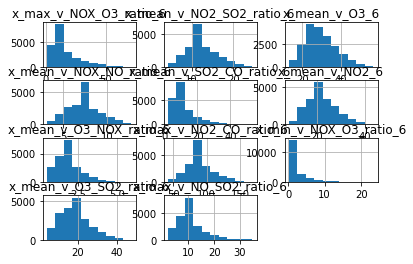

In [ ]:
X[varc].hist()

<AxesSubplot:>

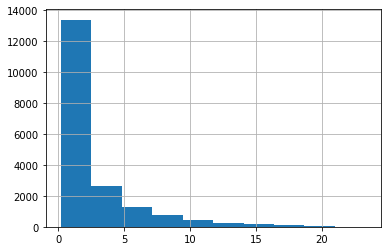

In [ ]:
X['x_min_v_NOX_O3_ratio_6'].hist()

# TAD Final

In [ ]:
tad = X.merge(y, on = um , how='inner')

In [ ]:
tad = tad[ um + varc + ['y'] ]

In [ ]:
tad.to_pickle('GOMEZ_AUSSENAC_LUIS_CONTAMINANTES.pkl')

# Modelo

###### Ajustes opcional

In [ ]:
tad.shape

(19208, 14)

<AxesSubplot:>

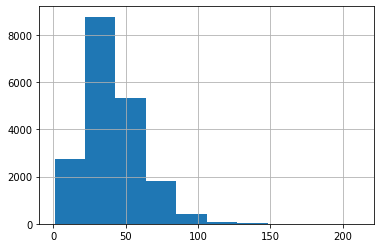

In [ ]:
tad['y'].hist()

In [ ]:
tad = tad.loc[tad['y'] < 150 ].reset_index(drop=True)

In [ ]:
tad.shape

(19199, 14)

<AxesSubplot:>

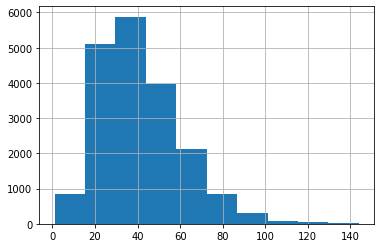

In [ ]:
tad['y'].hist()

## Partición de datos

In [ ]:
X, y = tad[varc].copy() , tad['y']

In [ ]:
Xt, Xv, yt, yv = train_test_split( X, y, train_size=0.7  )

## Regresión Lineal

In [ ]:
modelo = LinearRegression(n_jobs=-1)

In [ ]:
modelo.fit(Xt,yt)

LinearRegression(n_jobs=-1)

In [ ]:
modelo.coef_ , modelo.intercept_

(array([ 0.14162324, -0.61395191, -0.31566539,  0.67015496,  0.04551016,
         0.63368637, -0.4892264 , -0.06783616, -0.38719535,  0.12079666,
         0.02270962]),
 41.869381352475244)

## Desempeño

In [ ]:
mean_absolute_error( y_pred = modelo.predict(Xt) , y_true = yt )

14.423970662987237

In [ ]:
mean_absolute_error( y_pred = modelo.predict(Xv) , y_true = yv )

14.678308873308863

(array([   4.,  101.,  705., 1649., 1597.,  933.,  489.,  201.,   66.,
          15.]),
 array([26.50700628, 29.78880788, 33.07060949, 36.35241109, 39.6342127 ,
        42.9160143 , 46.1978159 , 49.47961751, 52.76141911, 56.04322072,
        59.32502232]),
 <BarContainer object of 10 artists>)

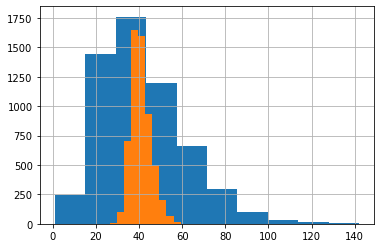

In [ ]:
yv.hist()
plt.hist( modelo.predict(Xv) )

In [ ]:
Xv['y']  = yv
Xv['y^'] = modelo.predict(Xv[varc])

In [ ]:
Xv['diff'] = Xv['y'] - Xv['y^']

<AxesSubplot:>

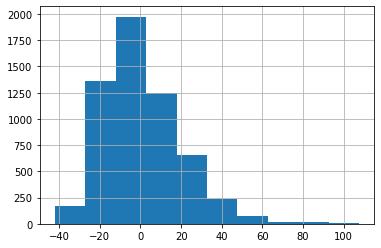

In [ ]:
Xv['diff'].hist()